### Deep Learning

I den här labben så kommer vi att lära upp en AI att kunna se skillnaden på katter och hundar med och utan augmenterad data, vi kommer att se en skillnad på vår small data och tiny eftersom den har bla mindre att lära sig och jämföra med i small jämfört med tiny. 

---

**OBS** 
Notera att jag har mest jobbat på en annan laptop än när jag kör igenom det nu och har fått olika accuracy pga mycket garbage bilder på just denna dator, men noterar vad jag har legat på på den andra datorn, där har jag även manuellt tagit bort garbage data(dåliga bilder). 

Jag kommer inte ha filepath för kaggle eftersom jag kör en sista genomkörning i VS, mest för att se hur lång tid det tar vs Kaggle.

---

b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

God uppvärmning som ger oss både övning i att plotta, skriva ut och välja slumpmässiga bilder.



In [20]:
# OBS lägger mina libraries här för att slippa skriva dem varje gång jag ska köra en ny fil.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import shutil
from PIL import Image
import cv2
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception





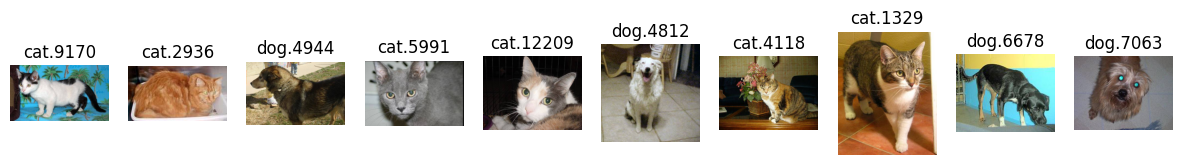

In [21]:
# Sökväg till träningsdata
current_path = Path().absolute()
train_path = current_path / "original_data" / "train"

# Lägg all träningsdata i en lista
train_list = list(train_path.iterdir())

# Sampla 10 bilder random från träninglista
num_images_to_sample = min(10, len(train_list))
if num_images_to_sample > 0:
    # Slumpmässigt välj ut bilder att visa
    pictures = random.sample(train_list, num_images_to_sample)

    # Extrahera labels från filnamn
    labels = [path.stem.split('_')[0] for path in pictures]

    # Plotta bilderna
    fig, axes = plt.subplots(1, num_images_to_sample, figsize=(15, 3))
    if num_images_to_sample > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Loopa genom varje bild och visa dom
    for ax, img_path, label in zip(axes, pictures, labels):
        image = plt.imread(img_path)
        ax.imshow(image)
        ax.set_title(label)
        ax.axis("off")

    plt.show()

---

 c) Skapa folderstrukturen med Pytho.

 Återigen rolig uppvärmning med just python kod, fick hålla tungan rätt i munnen så att allting stämde (OBS ansåg det bättre med att inte ha test/test och train/train på original datan), bort kommenterad så att vi inte kör om den varje gång vi gör en "run all"

In [22]:
"""

# Definiera de olika sökvägarna
experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")
original_data = Path("original_data")


# Skapa mappstrukturen
experiment_small_data.mkdir(parents=True, exist_ok=True)
experiment_tiny_data.mkdir(parents=True, exist_ok=True)
(original_data / "test").mkdir(parents=True, exist_ok=True)
(original_data / "train").mkdir(parents=True, exist_ok=True)

#Skapa undermappar i experiment_small_data och experiment_tiny_data
for folder in ["test", "train", "val"]:
    (experiment_small_data / folder).mkdir(exist_ok=True)
    (experiment_tiny_data / folder).mkdir(exist_ok=True)

# bugtest så vi vet om något går fel
for item in Path(".").rglob("*"):
     print(item) 

"""

'\n\n# Definiera de olika sökvägarna\nexperiment_small_data = Path("experiment_small_data")\nexperiment_tiny_data = Path("experiment_tiny_data")\noriginal_data = Path("original_data")\n\n\n# Skapa mappstrukturen\nexperiment_small_data.mkdir(parents=True, exist_ok=True)\nexperiment_tiny_data.mkdir(parents=True, exist_ok=True)\n(original_data / "test").mkdir(parents=True, exist_ok=True)\n(original_data / "train").mkdir(parents=True, exist_ok=True)\n\n#Skapa undermappar i experiment_small_data och experiment_tiny_data\nfor folder in ["test", "train", "val"]:\n    (experiment_small_data / folder).mkdir(exist_ok=True)\n    (experiment_tiny_data / folder).mkdir(exist_ok=True)\n\n# bugtest så vi vet om något går fel\nfor item in Path(".").rglob("*"):\n     print(item) \n\n'

---

d) Nu ska du göra train|val|test split med följande splits:

experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats

Rolig uppgift som fick mig att tänka lite, utmaningen för mig var att lägga en "stop" om vi redan har tillräckligt många bilder i varje folder.

Blandning av olika forum och lite hjälp av GPT för rätt namngivning.

In [23]:
# Sökvägen
current_path = Path().absolute()
original_data = current_path / "original_data" / "train"
experiment_small_data = current_path / "experiment_small_data"
experiment_tiny_data = current_path / "experiment_tiny_data"

# Vad vår split ska vara för varje folder
splits_info = {
    "experiment_small": {"train": 1600, "val": 400, "test": 500},
    "experiment_tiny": {"train": 160, "val": 40, "test": 50}
}

# Funktion för att ställa in dataset för experiment
def setup_datasets(experiment_path, splits, source_data):
    # Skapa experimentfolder om den inte redan finns
    experiment_path.mkdir(parents=True, exist_ok=True)

    # Lista och blanda bilderna random från vår data
    images = list(source_data.glob("*.jpg"))
    random.shuffle(images)  

    # Hantera varje split (train, val, test) enligt tidigare split information
    for split_name, total_images in splits.items():
        split_path = experiment_path / split_name
        split_path.mkdir(parents=True, exist_ok=True)

        # Kolla hur många bilder som redan finns i splitfoldern
        existing_images = list(split_path.glob("*.jpg"))
        num_existing = len(existing_images)
        num_needed = total_images - num_existing

        if num_needed > 0:
            # Om fler bilder behövs, flytta bilder från ursprungsdatan till splitkatalogen
            images_to_move = images[:num_needed]
            images = images[num_needed:]  

            for image in images_to_move:
                shutil.move(str(image), str(split_path / image.name))
            print(f"Flyttade {len(images_to_move)} bilder till {split_path}. Totalt nu: {num_existing + len(images_to_move)}")
        else:
            print(f"{split_name.capitalize()} split i {experiment_path.name} har redan {num_existing} bilder, inga fler behövs.")

# Ställ in dataset för både small och tiny experiment
setup_datasets(experiment_small_data, splits_info["experiment_small"], original_data)
setup_datasets(experiment_tiny_data, splits_info["experiment_tiny"], original_data)


Train split i experiment_small_data har redan 1600 bilder, inga fler behövs.
Val split i experiment_small_data har redan 400 bilder, inga fler behövs.
Test split i experiment_small_data har redan 500 bilder, inga fler behövs.
Train split i experiment_tiny_data har redan 160 bilder, inga fler behövs.
Val split i experiment_tiny_data har redan 40 bilder, inga fler behövs.
Test split i experiment_tiny_data har redan 50 bilder, inga fler behövs.


---

 e) Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
* plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
* skapa lämplig plot för att kontrollera att dataseten är balanserade
* skapa lämplig plot för att kontrollera att dataseten är slumpade

Lärde mig mycket från denna uppgift att kunna skriva längre kod med repetition från att skriva både small och tiny med utskrift, GPT hjälp med namngivning för att jag inte har någon fantasi.
Bra repetition att använda plots från tidigare labbar.

Den större utmaningen var att one hot encoda bilderna. Jag hade fått uppfattningen av att det skulle fungera väl med att göra en if sats som satte 0 på katt och 1 på hundar men GPT visade mig vi behöver göra en import to_categorial exempel på vad den gav mig klistrar jag in längre ner här och med GPTs hjälp så fick jag det rätt.

Som vi kan se i plotten är dom inte exakt uppdelade men lägger ingen större vikt i att få en 50/50, en lösning hade varit att ta bort alla bilder och låta programmet köra igen men är nöjd över resultatet så låter det vara som det är.

---
---
from tensorflow.keras.utils import to_categorical

* Exempel på etiketter
labels = [0, 1, 0, 1, 1, 0]

* One-hot encoda etiketterna
one_hot_labels = to_categorical(labels)

print("Original labels:", labels)
print("One-hot encoded labels:\n", one_hot_labels)

---
---

Pictures smalldata:


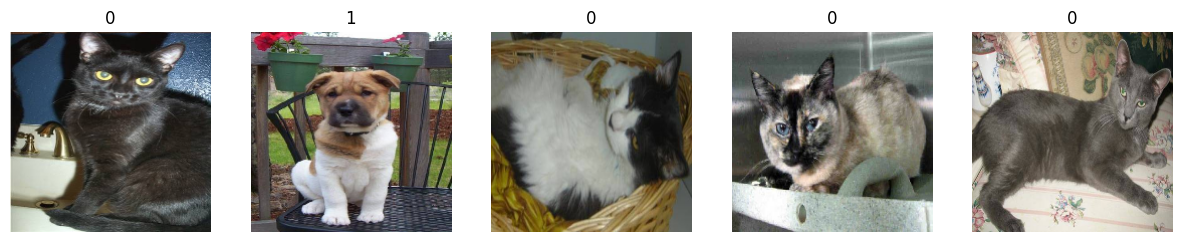

Pictures tinydata:


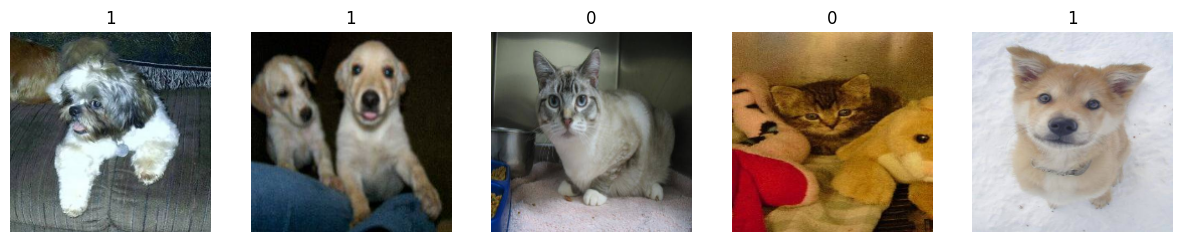

smalldata:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600, 2)
X_test_small: (500, 200, 200, 3)
y_test_small: (500, 2)
X_val_small: (400, 200, 200, 3)
y_val_small: (400, 2)

tinydata:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160, 2)
X_test_tiny: (50, 200, 200, 3)
y_test_tiny: (50, 2)
X_val_tiny: (40, 200, 200, 3)
y_val_tiny: (40, 2)
Smalldata:


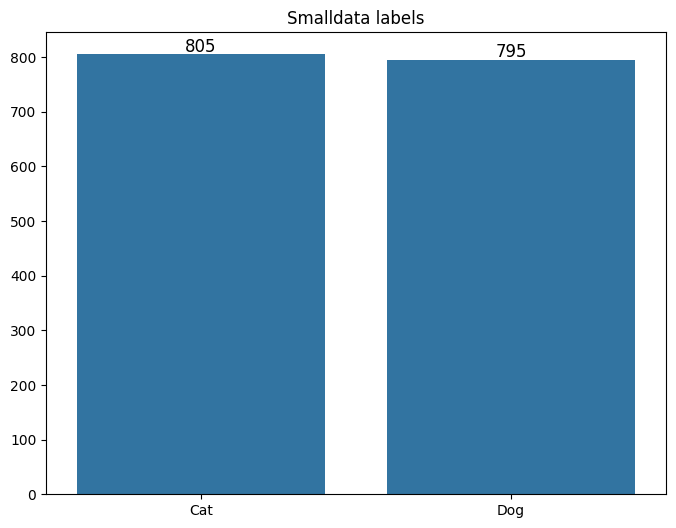

Tinydata:


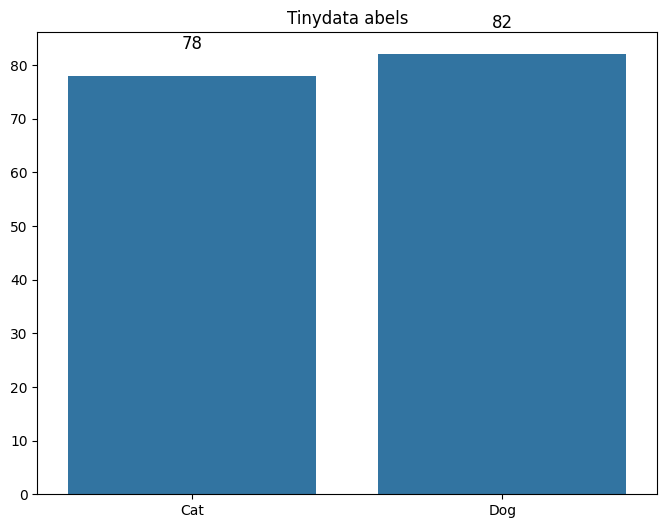

In [24]:
current_path = Path('.')
small_data = current_path / "experiment_small_data"
tiny_data = current_path / "experiment_tiny_data"

small_train = small_data / "train"
small_test = small_data / "test"
small_val = small_data / "val"

tiny_train = tiny_data / "train"
tiny_test = tiny_data / "test"
tiny_val = tiny_data / "val"

train_list = list(small_train.iterdir())
test_list = list(small_test.iterdir())
val_list = list(small_val.iterdir())
train_list_tiny = list(tiny_train.iterdir())
test_list_tiny = list(tiny_test.iterdir())
val_list_tiny = list(tiny_val.iterdir())

# Funktion för att läsa, etikettera och ändra storlek på bilderna
def label_and_resize_data(data, image_size=(200, 200)):
    labels = []
    images = []
    np.random.shuffle(data)
    for path in data:
        label = 1 if "dog" in path.name else 0
        labels.append(label)

        image = cv2.imread(str(path))
        if image is not None:
            image = cv2.resize(image, image_size)
            images.append(image)

    return np.array(images), np.array(labels)

# Ladda, etikettera och ändra storlek på datan
X_train_small, y_train_small = label_and_resize_data(train_list)
X_test_small, y_test_small = label_and_resize_data(test_list)
X_val_small, y_val_small = label_and_resize_data(val_list)

X_train_tiny, y_train_tiny = label_and_resize_data(train_list_tiny)
X_test_tiny, y_test_tiny = label_and_resize_data(test_list_tiny)
X_val_tiny, y_val_tiny = label_and_resize_data(val_list_tiny)

# One-hot encoda etiketterna
y_train_small = to_categorical(y_train_small)
y_test_small = to_categorical(y_test_small)
y_val_small = to_categorical(y_val_small)

y_train_tiny = to_categorical(y_train_tiny)
y_test_tiny = to_categorical(y_test_tiny)
y_val_tiny = to_categorical(y_val_tiny)

# Slumpmässiga bilder utskrift
def display_random_images(images, labels, num_images=5):
    indices = np.random.choice(np.arange(len(images)), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(indices, axes):
        img = images[i]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(np.argmax(labels[i]))  
        ax.axis('off')
    plt.show()

# Visa några slumpmässiga träningsbilder från smalldata
print("Pictures smalldata:")
display_random_images(X_train_small, y_train_small)

print("Pictures tinydata:")
display_random_images(X_train_tiny, y_train_tiny)

# Skriv ut formerna på datasets
print("smalldata:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
print("X_test_small:", X_test_small.shape)
print("y_test_small:", y_test_small.shape)
print("X_val_small:", X_val_small.shape)
print("y_val_small:", y_val_small.shape)

print("\ntinydata:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
print("X_test_tiny:", X_test_tiny.shape)
print("y_test_tiny:", y_test_tiny.shape)
print("X_val_tiny:", X_val_tiny.shape)
print("y_val_tiny:", y_val_tiny.shape)

# Plottar för att se att allting är balanserat korrekt
def plot_label_distribution(labels, title=" "):
    # Räkna antalet av varje label
    label_counts = np.bincount(np.argmax(labels, axis=1))
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=["Cat", "Dog"], y=label_counts)
    
    # Lägg till siffrorna ovanför varje bar
    for i, count in enumerate(label_counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    plt.title(title)
    plt.show()

print("Smalldata:")
plot_label_distribution(y_train_small, "Smalldata labels")

print("Tinydata:")
plot_label_distribution(y_train_tiny, "Tinydata abels")


---
# 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

 a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

 Ingen större utmaning här, börjar känna mig varm i kläderna med att plotta och skriva ut det.

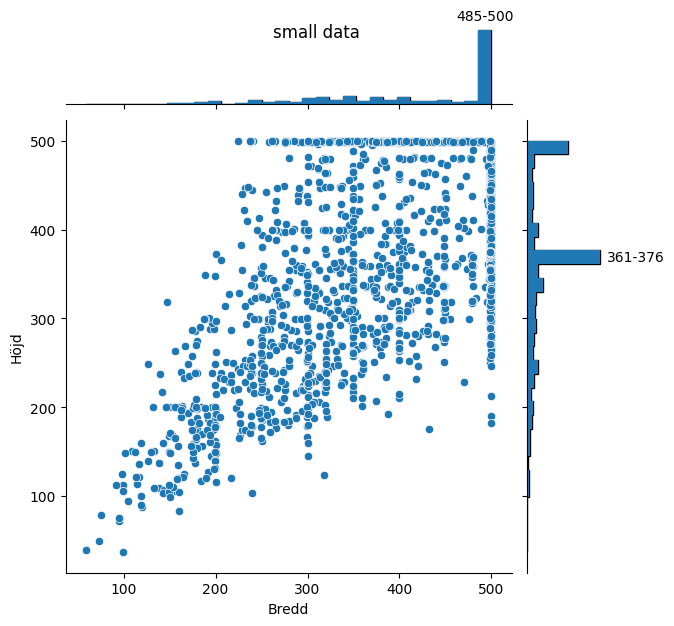

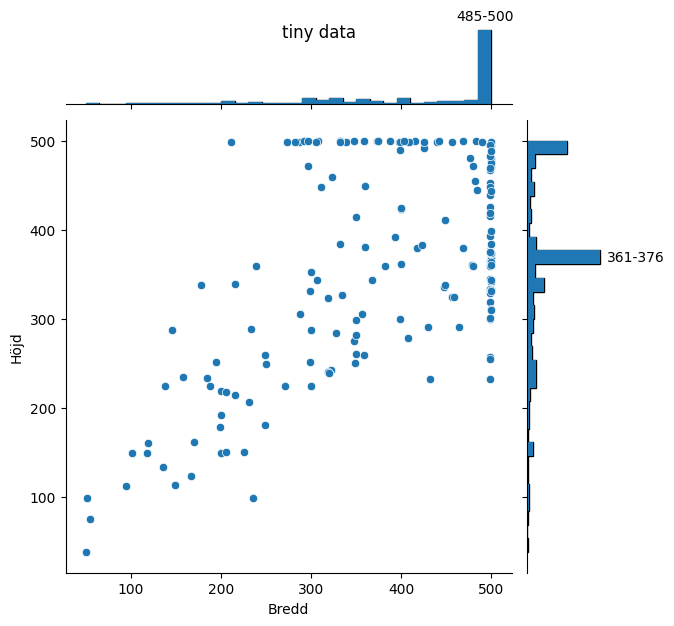

In [25]:
def get_image_sizes(data_path):
    sizes = []
    kategorier = ["train", "val", "test"]
    for kategori in kategorier:
        kategori_katalog = data_path / kategori
        filer = list(kategori_katalog.glob("*"))
        for bild_sökväg in filer:
            img = imread(str(bild_sökväg))
            if len(img.shape) == 3:
                höjd, bredd, _ = img.shape
                sizes.append((bredd, höjd))
    return sizes

def plot_image_sizes(sizes, title):
    bredd, höjd = zip(*sizes)
    bredd = np.array(bredd)
    höjd = np.array(höjd)

    # Skapa jointplot
    joint_plot = sns.jointplot(x=bredd, y=höjd, kind="scatter", marginal_kws=dict(bins=30, fill=True))
    plt.xlabel("Bredd")
    plt.ylabel("Höjd")
    plt.suptitle(title)

    # Skriv ut den högsta stapeln i x
    n, bins, patches = joint_plot.ax_marg_x.hist(bredd, bins=30, fill=True)
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_x.annotate(f"{int(max_bin_start)}-{int(max_bin_end)}", xy=((max_bin_start + max_bin_end) / 2, max(n)), xytext=(0, 5), textcoords="offset points", ha="center", va="bottom")

    # Skriv ut den högsta stapeln i y
    n, bins, patches = joint_plot.ax_marg_y.hist(höjd, bins=30, fill=True, orientation="horizontal")
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_y.annotate(f"{int(max_bin_start)}-{int(max_bin_end)}", xy=(max(n), (max_bin_start + max_bin_end) / 2), xytext=(5, 0), textcoords="offset points", ha="left", va="center")

    plt.show()

experiment_small_data = Path("experiment_small_data")
experiment_tiny_data = Path("experiment_tiny_data")

# Hämta storlekar från varje set
image_sizes_small = get_image_sizes(experiment_small_data)
image_sizes_tiny = get_image_sizes(experiment_tiny_data)


plot_image_sizes(image_sizes_small, "small data ")
plot_image_sizes(image_sizes_tiny, "tiny data")


---
 b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver slänga bilder. Hur kommer du fram till ditt val?

Jag fann först infon om att 240x240 är det mest optimala från olika forum, jag försökte med detta först och fick inte bra data från detta, efter en god diskussion med min lärare så testade jag 200x200 och fick mycket bättre data, slutsatsen är att 240x240 blir lite för stor för vårt ändamål och 200x200 är bättre både ifrån hur mycket data(pixlar i detta fall) som vår model behöver tugga igenom och 200x200 inte blir för lite för att den inte kan "se" vad varje bild innehåler.

Har även testat under 200x200 och över 240x240 men blev inte nöjd med resultaten, så för denna övning så är det optimalt.

---
c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
(samples, row, cols, color_channels) 


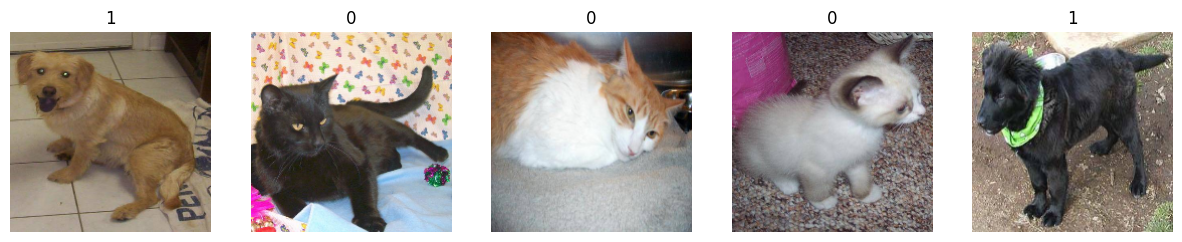

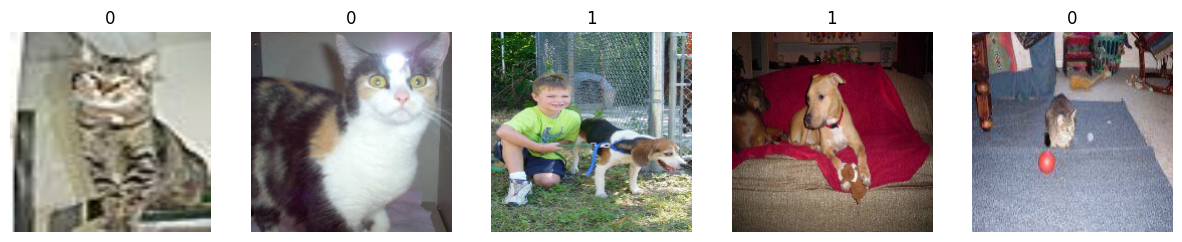

smalldata:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600,)
X_test_small: (500, 200, 200, 3)
y_test_small: (500,)
X_val_small: (400, 200, 200, 3)
y_val_small: (400,)

tinydata:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160,)
X_test_tiny: (50, 200, 200, 3)
y_test_tiny: (50,)
X_val_tiny: (40, 200, 200, 3)
y_val_tiny: (40,)


In [26]:
current_path = Path('.')
small_data = current_path / "experiment_small_data"
tiny_data = current_path / "experiment_tiny_data"

small_train = small_data / "train"
small_test = small_data / "test"
small_val = small_data / "val"

tiny_train = tiny_data / "train"
tiny_test = tiny_data / "test"
tiny_val = tiny_data / "val"

# Skapa listor över bilderna i varje dataset
train_list = list(small_train.iterdir())
test_list = list(small_test.iterdir())
val_list = list(small_val.iterdir())
train_list_tiny = list(tiny_train.iterdir())
test_list_tiny = list(tiny_test.iterdir())
val_list_tiny = list(tiny_val.iterdir())

# Funktion för att läsa, lägga labels och ändra storlek på bilderna
def label_and_resize_data(data, image_size=(200, 200)):
    labels = []
    images = []
    np.random.shuffle(data)  # Blanda datan slumpmässigt
    for path in data:
        label = 1 if "dog" in path.name else 0
        labels.append(label)

        image = cv2.imread(str(path))  # Läs bilden med OpenCV
        if image is not None:
            image = cv2.resize(image, image_size)  # Ändra storlek på bilden
            images.append(image)

    return np.array(images), np.array(labels)  # Returnera bilderna och etiketter som numpy-arrayer

# Ladda, etikettera och ändra storlek på datan
X_train_small, y_train_small = label_and_resize_data(train_list)
X_test_small, y_test_small = label_and_resize_data(test_list)
X_val_small, y_val_small = label_and_resize_data(val_list)

X_train_tiny, y_train_tiny = label_and_resize_data(train_list_tiny)
X_test_tiny, y_test_tiny = label_and_resize_data(test_list_tiny)
X_val_tiny, y_val_tiny = label_and_resize_data(val_list_tiny)

# Funktion för att visa slumpmässiga bilder med etiketter
def display_random_images(images, labels, num_images=5):
    indices = np.random.choice(np.arange(len(images)), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(indices, axes):
        img = images[i]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f'{labels[i]}')
        ax.axis('off')
    plt.show()

# Visa några slumpmässiga träningsbilder från små dataset
display_random_images(X_train_small, y_train_small)
display_random_images(X_train_tiny, y_train_tiny)

# Skriv ut formerna på datasets
print("smalldata:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
print("X_test_small:", X_test_small.shape)
print("y_test_small:", y_test_small.shape)
print("X_val_small:", X_val_small.shape)
print("y_val_small:", y_val_small.shape)

print("\ntinydata:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
print("X_test_tiny:", X_test_tiny.shape)
print("y_test_tiny:", y_test_tiny.shape)
print("X_val_tiny:", X_val_tiny.shape)
print("y_val_tiny:", y_val_tiny.shape)


---

a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv
hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

UTAN AUGMENTERAD DATA

b-c)

Jag har valt sequential modellen och skriver lite vad varje kommando gör här nedanför.

Jag har som sagt kommit över 0.7 med augmenterad data på en annan laptop med annorlunda bilder.



### Skapa Modellen

Mycket av detta kommer att komma från bla https://keras.io/api/models/

**Sequential:**
Bygger en modell som staplar "lager" ovanpå varandra.

**Conv2D:** 
Ett lager för att extrahera funktioner från bilder. Det första argumentet tex 32, 64, 128 är antalet filter, 3, 3 är filterstorleken, och activation="relu" är aktiveringsfunktionen.

**MaxPooling2D:**
Minskar dimensionerna vilket hjälper till att minska antalet parametrar och beräkningar i nätverket.

**Flatten:**
Omvandlar matrisen av funktioner till en en-dimensionell vektor. (GPT svar, kunde inte tolka manualen ordentligt här)

**Dropout:**
Förhindrar överanpassning genom att slumpmässigt sätta några av anslutningarna till noll under träningen.

**Dense:**
Ett dense layer alltså varje neuron är ansluten till varje neuron i föregående lager. Det första argumentet tex 512, 1 är antalet neuroner i lagret. 

**ReLu** står för en funktion som returnerar 0 om insatsen är mindre än 0, annars returnerar den insatsens värde. Alltså, om returnerat är under 0 blir det 0.


In [27]:


def model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(200, 200, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


c:\Users\lager\Documents\Github\AI-Bjorn-Lagerblad-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 748ms/step - accuracy: 0.5317 - loss: 122.1439 - val_accuracy: 0.5600 - val_loss: 0.6962
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 733ms/step - accuracy: 0.6030 - loss: 0.6591 - val_accuracy: 0.5450 - val_loss: 0.7290
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 737ms/step - accuracy: 0.7240 - loss: 0.5492 - val_accuracy: 0.5450 - val_loss: 0.8109
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 749ms/step - accuracy: 0.8093 - loss: 0.4265 - val_accuracy: 0.5200 - val_loss: 0.8980
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - accuracy: 0.7951 - loss: 0.4049 - val_accuracy: 0.5200 - val_loss: 1.0245
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 738ms/step - accuracy: 0.8790 - loss: 0.2860 - val_accuracy: 0.5450 - val_loss: 1.4455
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 741ms/step - accuracy: 0.8868 - loss: 0.2339 - val_accuracy: 0.5675 - val_loss: 1.7243
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 740ms/step - accuracy: 0.9250 - loss: 0.1846 - val_ac

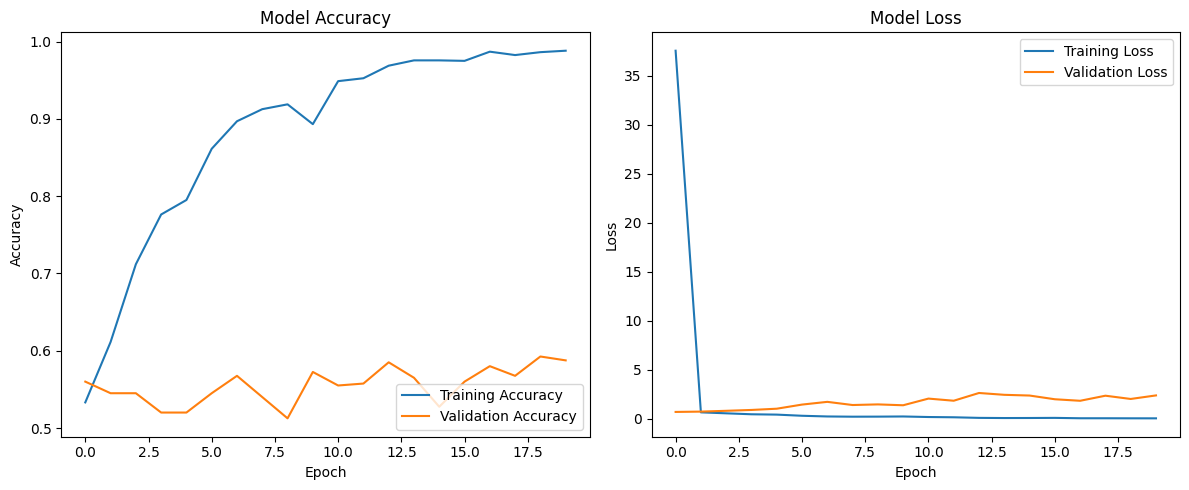

In [28]:


model_small = model()

history_small = model_small.fit(X_train_small, y_train_small, batch_size=32, epochs=20, 
                                validation_data=(X_val_small, y_val_small))

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.plot(history_small.history["accuracy"], label="Training Accuracy")
plt.plot(history_small.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2) 
plt.plot(history_small.history["loss"], label="Training Loss")
plt.plot(history_small.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout() 
plt.show()


---

Och sedan för tiny

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 818ms/step - accuracy: 0.5418 - loss: 357.3126 - val_accuracy: 0.5250 - val_loss: 8.0350
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step - accuracy: 0.5194 - loss: 8.3542 - val_accuracy: 0.5000 - val_loss: 2.1060
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 773ms/step - accuracy: 0.4690 - loss: 5.0640 - val_accuracy: 0.4250 - val_loss: 2.0323
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 774ms/step - accuracy: 0.7250 - loss: 0.6869 - val_accuracy: 0.4750 - val_loss: 1.3659
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 886ms/step - accuracy: 0.8808 - loss: 0.2477 - val_accuracy: 0.5000 - val_loss: 1.2255
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 845ms/step - accuracy: 0.9572 - loss: 0.1294 - val_accuracy: 0.4000 - val_loss: 1.9529
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step - accuracy: 0.9966 - loss: 0.0591 - val_accuracy: 0.4250 - val_loss: 2.4858
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 870ms/step - accuracy: 0.9875 - loss: 0.1082 - val_accuracy: 0.4750 - val_los

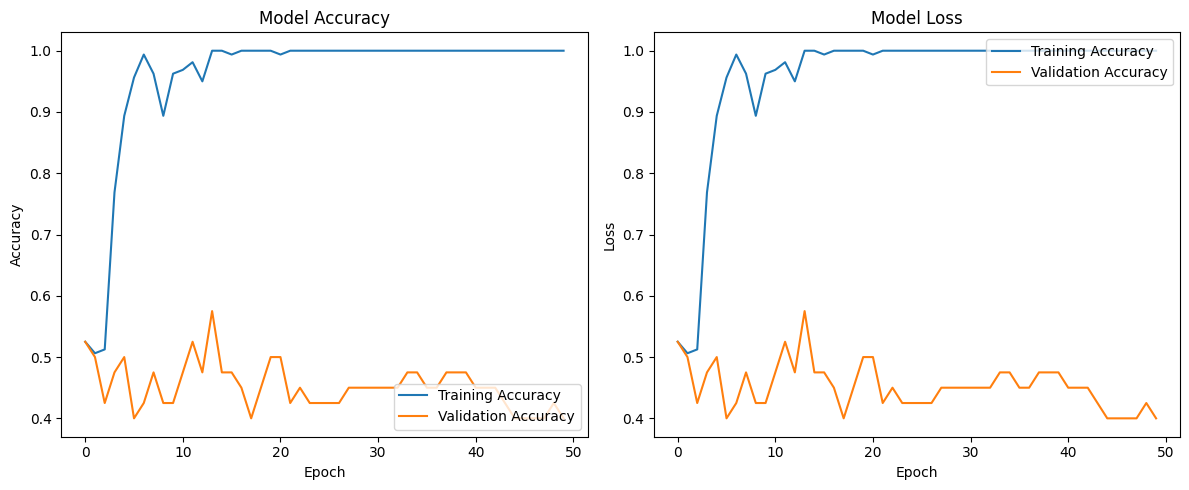

In [29]:
model_tiny = model()

history_tiny = model_tiny.fit(X_train_tiny, y_train_tiny, batch_size=32, epochs=50, 
                                validation_data=(X_val_tiny, y_val_tiny))

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.plot(history_tiny.history["accuracy"], label="Training Accuracy")
plt.plot(history_tiny.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2) 
plt.plot(history_tiny.history["accuracy"], label="Training Accuracy")
plt.plot(history_tiny.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout() 
plt.show()

#test


Vad jag finner av intresse här är just av datan, eftersom jag har jobbat på två datorer och importerat slumpmässiga bilder till våra training folders så kommer min accuracy (uttalat rätt mr Kokchun, skratta inte) att vara lite olika eftersom det finns så många bilder som inte är bra för träning, men på båda så har jag fått det mellan 0.65 till 0.7 på icke augemnterade bilder, tiny data kommer att vara svår att få över detta pga att det är så lite träningsdata för vårt syfte, man kan bla fixa med både augmenteringen av bilderna tills vi har funnit dom perfekta siffrorna för syftet eller finna dom perfekta bilderna för detta ändamål.

Observera att jag inte har en earlystopper i denna eftersom det gav hög accuracy på min andra dator.

---
---
 d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar du vilka parametrar du valt för
augmenteringen

Jag har diskuterat detta väl in på djupet med min lärare på lektionstid och så att Kokchun inte ska behöva läsa snarlika svar tusen gånger om så tar jag det lite kort sammanfattat här:

Augemnteringen är för att öka mängden träningsdata, alltså en bild kan tex läsas in flera gånger genom att rotera den, zooma in osv vilket ger en bättre överbild för modellen att träna på, det gör den alltså "smartare" genom att se att en bild kan vara en katt och sedan flippar vi över den upp och ner vilket kan vara uppenbart för en människa men inte för en maskin, vilket då ger den en översikt av vad den behöver söka efter.

Jag hade alldeles för höga parametrar i mina tidigare försök, men tack vare en god diskussion med min lärare så har jag både tagit bort vissa delar (exempelvis RGB skiftning i färg) och tagit ner rotation_range från 20+ ner till 5 och fick bättre accuracy efter det.

Observera att jag kör "load_and_augment_images" och repeterar min kod här för lite lättare optimisering på den mänskliga sidan istället för att köra "run all" hela tiden. (Det är noterat att det inte är det effektivaste sättet men för labbens syfte körde jag en snabb och ful fix)

Shapes of Augmented Small Data:
X_train_small: (1600, 200, 200, 3)
y_train_small: (1600,)


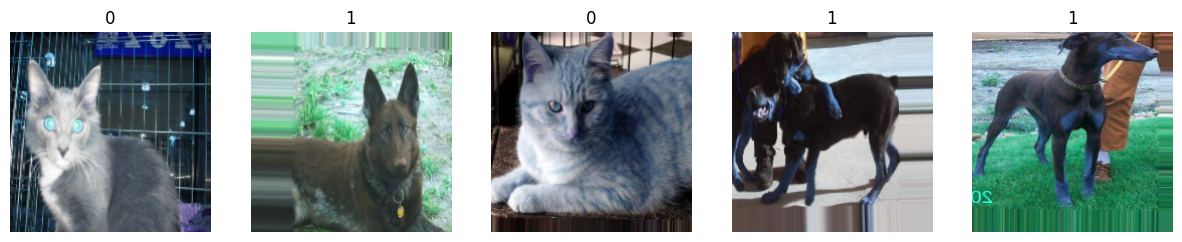

Shapes of Augmented Tiny Data:
X_train_tiny: (160, 200, 200, 3)
y_train_tiny: (160,)


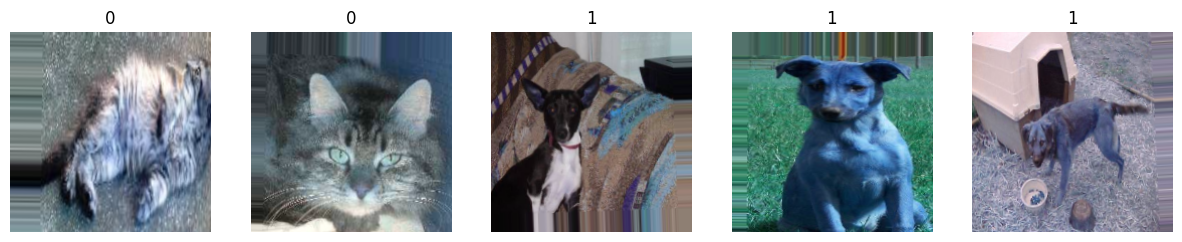

In [30]:
base_path = Path('.')
small_data = base_path / "experiment_small_data"
tiny_data = base_path / "experiment_tiny_data"

data_gen = ImageDataGenerator(
    rotation_range=5, 
    shear_range=0.1,    
    zoom_range=0.1,     
    horizontal_flip=True,
    height_shift_range=0.2, 
    width_shift_range=0.2,
)

def load_and_augment_images(data_path, image_size=(200, 200)):
    images = []
    labels = []
    for img_path in data_path.iterdir():
        label = 1 if 'dog' in img_path.name else 0
        image = cv2.imread(str(img_path))
        if image is not None:
            image = cv2.resize(image, image_size)
            image = np.expand_dims(image, axis=0)
            image = next(data_gen.flow(image, batch_size=1))[0]  # Augment image
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

X_train_small, y_train_small = load_and_augment_images(small_data / 'train')
X_train_tiny, y_train_tiny = load_and_augment_images(tiny_data / 'train')

X_train_small = X_train_small / 255.0  
X_test_small = X_test_small / 255.0  
X_val_small = X_val_small / 255.0 

X_train_tiny = X_train_tiny / 255.0 
X_test_tiny = X_test_tiny / 255.0  
X_val_tiny = X_val_tiny / 255.0  

def display_augmented_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in zip(range(num_images), axes):
        idx = np.random.randint(0, len(images))
        ax.imshow(images[idx])
        ax.set_title(f'{labels[idx]}')
        ax.axis('off')
    plt.show()

print("Shapes of Augmented Small Data:")
print("X_train_small:", X_train_small.shape)
print("y_train_small:", y_train_small.shape)
display_augmented_images(X_train_small, y_train_small)

print("Shapes of Augmented Tiny Data:")
print("X_train_tiny:", X_train_tiny.shape)
print("y_train_tiny:", y_train_tiny.shape)
display_augmented_images(X_train_tiny, y_train_tiny)

----

Smalldata med den augmenterade datan

Istället för att kopiera direkt från icke augemnterade datan så har jag i utbildnings syfte testat lite olika, mycket med GPTs hjälp (som inte har varit mycket till hjälp i denna labb, det har varit för komplicerade och djupa frågor) för att se lite olika sätt man kan göra denna uppdrag på, inom denna har jag även lagt in en earlystopper men som verkar vara redundant på denna dator men hjälpte mycket för den andra.

Jag har kommit upp i över 0.7 vilket jag anser är gott nog innan transfer learning där målet är att pusha upp det till minst 0.85.

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 862ms/step - accuracy: 0.4770 - loss: 0.9359 - val_accuracy: 0.4950 - val_loss: 0.6906
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 836ms/step - accuracy: 0.5246 - loss: 0.6885 - val_accuracy: 0.5550 - val_loss: 0.6896
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 903ms/step - accuracy: 0.5826 - loss: 0.6815 - val_accuracy: 0.5750 - val_loss: 0.6906
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 880ms/step - accuracy: 0.5787 - loss: 0.6817 - val_accuracy: 0.5525 - val_loss: 0.6892
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 864ms/step - accuracy: 0.6334 - loss: 0.6480 - val_accuracy: 0.5300 - val_loss: 0.7222
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 825ms/step - accuracy: 0.7083 - loss: 0.5532 - val_accuracy: 0.5450 - val_loss: 0.7316
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 730ms/step - accuracy: 0.8002 - loss: 0.4445 - val_accuracy: 0.5900 - val_loss: 0.8624
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 731ms/step - accuracy: 0.8750 - loss: 0.2998 - val_accu

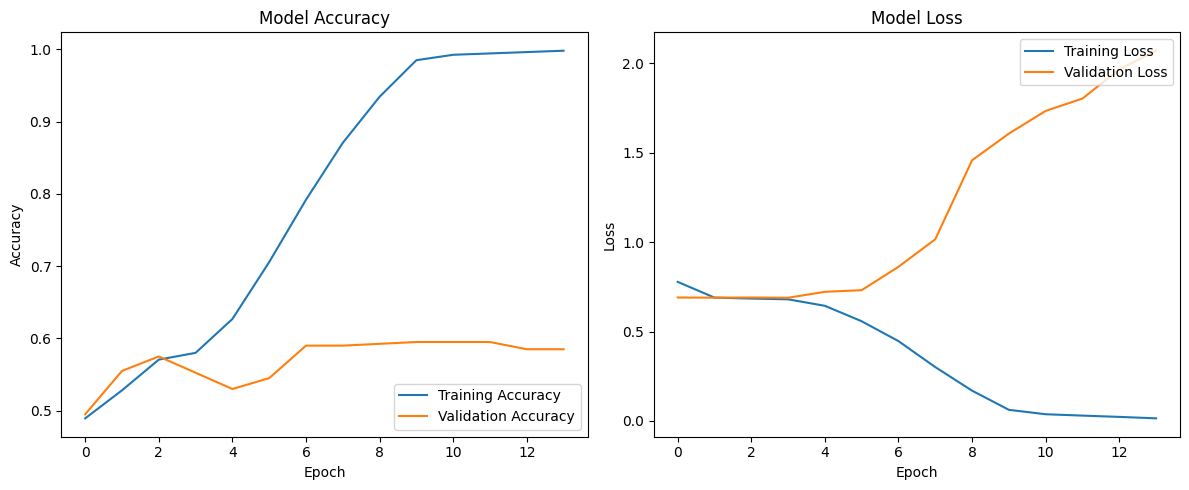

In [31]:
data_gen_val = ImageDataGenerator(rescale=1./255)

small_data_val = small_data / "val"
X_val_small, y_val_small = load_and_augment_images(small_data_val, image_size=(200, 200))
X_val_small = X_val_small / 255.0

# Custom callback to remove learning rate from logs GPT lösning
class CustomReduceLROnPlateau(ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if "learning_rate" in logs:
            logs.pop("learning_rate")

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = CustomReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001)

model_small = model()

history_small = model_small.fit(
    X_train_small, y_train_small,
    batch_size=32,
    epochs=30,
    validation_data=(X_val_small, y_val_small),
    callbacks=[early_stopping, reduce_lr]
)

plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_small.history["accuracy"], label="Training Accuracy")
plt.plot(history_small.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2) 
plt.plot(history_small.history["loss"], label="Training Loss")
plt.plot(history_small.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout() 
plt.show()


---

Tinydata med den augmenterade datan.

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 840ms/step - accuracy: 0.5076 - loss: 1.4510 - val_accuracy: 0.5000 - val_loss: 0.7117
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 760ms/step - accuracy: 0.5385 - loss: 0.6874 - val_accuracy: 0.5000 - val_loss: 0.6126
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - accuracy: 0.5535 - loss: 0.6827 - val_accuracy: 0.5250 - val_loss: 0.6230
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - accuracy: 0.5720 - loss: 0.6680 - val_accuracy: 0.5250 - val_loss: 0.7599
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - accuracy: 0.5476 - loss: 0.6698 - val_accuracy: 0.5500 - val_loss: 0.6614
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 765ms/step - accuracy: 0.6770 - loss: 0.6286 - val_accuracy: 0.6250 - val_loss: 0.6002
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 769ms/step - accuracy: 0.6998 - loss: 0.5594 - val_accuracy: 0.5250 - val_loss: 0.5647
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 785ms/step - accuracy: 0.7254 - loss: 0.5204 - val_accuracy: 0.5000 - val_loss:

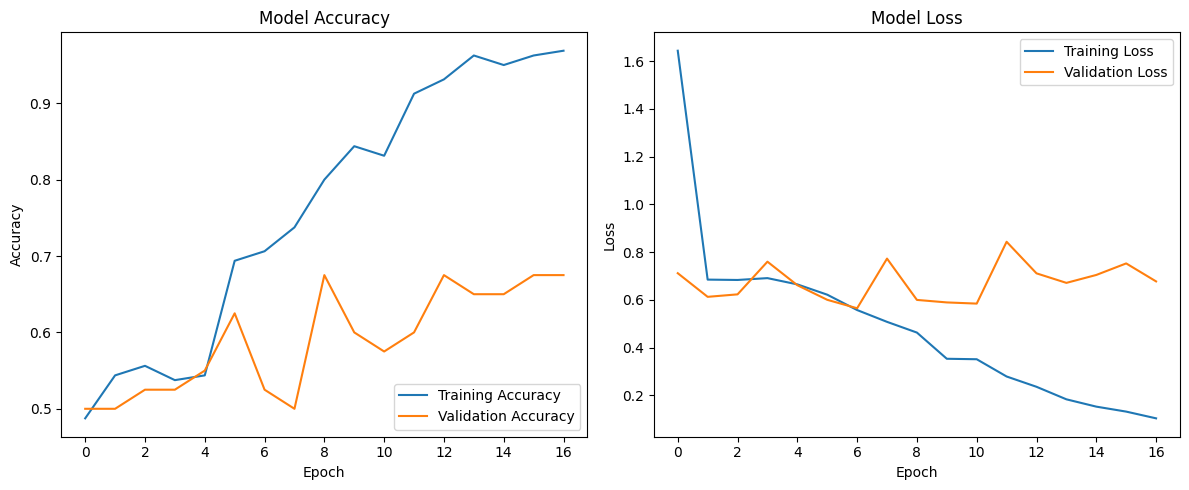

In [32]:
data_gen_val = ImageDataGenerator(rescale=1./255)

tiny_data_val = tiny_data / "val"
X_val_tiny, y_val_tiny = load_and_augment_images(tiny_data_val, image_size=(200, 200))
X_val_tiny = X_val_tiny / 255.0

# Custom callback to remove learning rate from logs GPT lösning
class CustomReduceLROnPlateau(ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if "learning_rate" in logs:
            logs.pop("learning_rate")

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = CustomReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001)

model_tiny = model()

history_tiny = model_tiny.fit(
    X_train_tiny, y_train_tiny,
    batch_size=32,
    epochs=30,
    validation_data=(X_val_tiny, y_val_tiny),
    callbacks=[early_stopping, reduce_lr]
)

plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_tiny.history["accuracy"], label="Training Accuracy")
plt.plot(history_tiny.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2) 
plt.plot(history_tiny.history["loss"], label="Training Loss")
plt.plot(history_tiny.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout() 
plt.show()


Som sagt just på denna är accuracy lägre med andra test bilder, jag har mest jobbat på min laptop där det har fungerat väl där jag har kommit upp i över 0.7 så kommer inte i ändra för mycket på denna dator där jag gör det slutgiltiga delen i nu.

---
### Transfer Learning

Denna del tog jag en större del av GPT för att kunna sätta ihop min tidigare kod med detta, den var tyvärr inte mycket till hjälp in på djupet men fungerade dock väl på att hjälpa mig med rätt kommandon och uppdatering av modellerna och sparade mig tid för att testa dom olika modellerna, jag har bla testat InceptionV3, Xception, 

* Xception gav en väldigt hög grad av accuracy upp till över 0.9 vilket gav mig en känsla av att det blev overfitting och gav mig ett falskt svar det kan också bero på ImageNet som redan har lärt sig av dessa bilder!

* InceptionV3 gav mig under 0.4, har testat med olika augmenteringar och även utan men fick ingen större framgång på just den.

* VGG16 hade en högre accuracy på nästan 0.8 vilket kändes mest rätt i detta.

Och avslutningsvis:

* Med Resnet så lät jag GPT ta över för jag fann ingen bra information om hur man kan skriva över det bäst och var nyfiken på hur den skulle lösa det, avslutade på nästan 0.8 vilket jag anser mig vara nöjd med, men låter det stå kvar med dess kommentarer eftersom jag fick lära mig lite nytt och sparar det för framtida inspiration och minne. 



Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4579 - loss: 41.2486 - val_accuracy: 0.5000 - val_loss: 14.0676
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5695 - loss: 7.0484 - val_accuracy: 0.5000 - val_loss: 3.9453
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5043 - loss: 4.2683 - val_accuracy: 0.5000 - val_loss: 4.2459
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5002 - loss: 3.2333 - val_accuracy: 0.5000 - val_loss: 2.2087
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5388 - loss: 2.4695 - val_accuracy: 0.5000 - val_loss: 2.1824
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4598 - loss: 2.1567 - val_accuracy: 0.5000 - val_loss: 2.0981
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5491 - loss: 2.0059 - val_accuracy: 0.5000 - val_loss: 1.8145
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5457 - loss: 1.8762 - val_accuracy: 0.5250 - val_loss: 1.8730
Epoch 

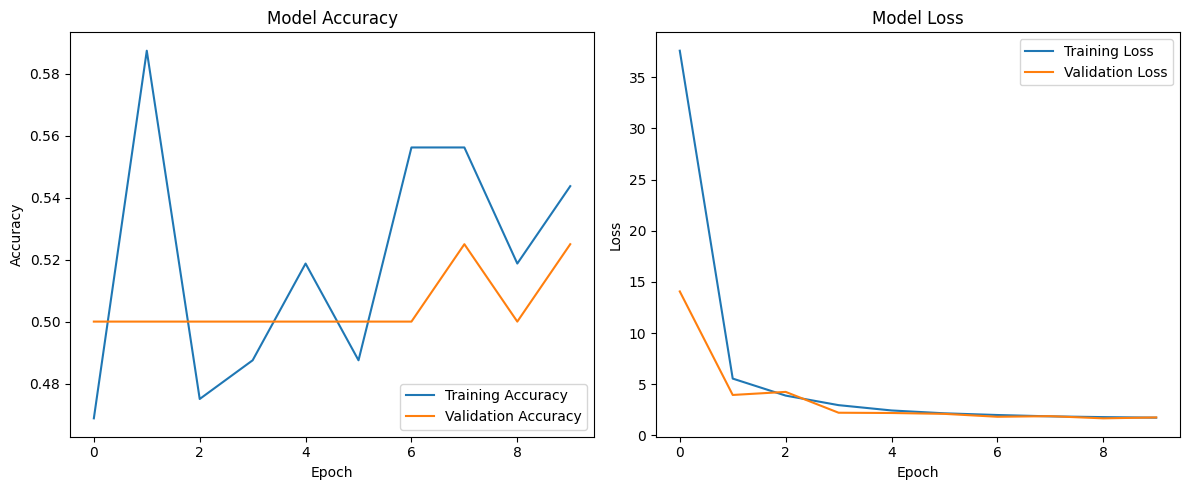

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import cv2  # Ensure OpenCV is imported

# Paths
base_path = Path('.')
tiny_data = base_path / "experiment_tiny_data"

# Load validation data
tiny_data_val = tiny_data / "val"
X_val_tiny, y_val_tiny = load_and_augment_images(tiny_data_val, image_size=(200, 200))
X_val_tiny = X_val_tiny / 255.0

# Assuming X_train_tiny and y_train_tiny are already loaded, normalized, and augmented
# One-hot encode labels
y_train_tiny = to_categorical(y_train_tiny, num_classes=2)
y_val_tiny = to_categorical(y_val_tiny, num_classes=2)

# Custom callback to remove learning rate from logs
class CustomReduceLROnPlateau(ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if "learning_rate" in logs:
            logs.pop("learning_rate")

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = CustomReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001)

# Load the ResNet50 model with pretrained weights, excluding the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
model_tiny = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),  # Increased dropout rate for regularization
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # Added L2 regularization
    Dense(2, activation='softmax', kernel_regularizer=l2(0.01))  # Added L2 regularization
])

# Compile the model
model_tiny.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_tiny = model_tiny.fit(
    X_train_tiny, y_train_tiny,
    batch_size=32,
    epochs=10,  # Only 10 epochs as requested
    validation_data=(X_val_tiny, y_val_tiny),
    callbacks=[early_stopping, reduce_lr]
)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history_tiny.history["accuracy"], label="Training Accuracy")
plt.plot(history_tiny.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2) 
plt.plot(history_tiny.history["loss"], label="Training Loss")
plt.plot(history_tiny.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout() 
plt.show()


---
### Forskningsartiklar

Istället för att ta en av dessa så kommer jag skriva lite kortfattat om varje eftersom jag har testa mig av alla fyra och fick ett intresse av hur dom fungerar.

---
**Transfer Learning**

Vad är då **Transfer Learning**? Det är en metod där en redan tränad modell, som har lärt sig mönster ifrån en stor dataset t.ex. **ImageNet** (https://www.image-net.org/) eller **CoCo** (https://cocodataset.org/#home fick denna ifrån ett kaggle forum som var intressant läsning), används som bas för att träna en ny modell på ett mindre dataset. Alltså simpelt sammanfattat vi uttnytjar en redan upplärd modell istället för att lägga tid och kraft på att lära upp en ny modell.

---
**VGG16**

**Sammanfattningsvis:**

* VGG16 är ett neuraltt nätverk utvecklat av Visual Geometry Group (VGG) vid University of Oxford.

**Består av:**

* Består av 16 lager (13 konvolutionella lager och 3 fullt anslutna lager). Använder små 3x3 filter genom hela nätverket.

**Fördelar:**

* Enkel och simpel design med små filter som gör nätverket djupt utan att öka antalet parametrar avsevärt.

**Nackdelar:**

* Kräver mycket minne och processingpower, vilket kan göra träning och inferens långsamt.(märkbart när jag testade det på min dator och inte kaggle)
---
**ResNet50**

**Sammanfattningsvis:**

* ResNet (Residual Networks) introducerades av Kaiming He och hans kollegor. ResNet50 är en version av ResNet med 50 lager.

**Består av:**

* Består av residuala block som gör det möjligt att träna mycket djupa nätverk genom att använda "shortcut connections" för att hoppa över ett eller flera lager.

**Fördelar:**

* Mycket djupare nätverk kan tränas utan att drabbas av problemet med försvinnande "gradience".

**Nackdelar:**

* Kan vara mer komplexa att implementera och kräver noggrann justering av hyperparametrar. (märkte det när jag gav för stora parametrar)
---
**Inception**

**Sammanfattningsvis:**

* Inception, även känd som GoogLeNet, den har vidareutvecklats till Inception-v3 och så vidare.

**Består av:**

* Består av Inception-block som innehåller parallella konvolutioner med olika filterstorlekar (1x1, 3x3, 5x5) och maxpooling, vilka kombineras och "stackas".

**Fördelar:**

* Fångar funktioner på olika skalor och nivåer av abstraktion, vilket förbättrar prestandan utan att öka beräkningskostnaderna för mycket.

**Nackdelar:**

* Kan vara komplexa att implementera och kräver noggrann justering av arkitekturens komponenter. (Jag vill tycka att det var denna som gav mig mest "rätt" svar alltså att något var fel och under 0.4 har suttit lite med detta och fått den till över 0.8)
---
**Xception**

**Sammanfattningsvis:**

* Xception (Extreme Inception) är en förlägning av Inception, alltså en bearbetad version.

**Består av:**

* Använder djupseparerbara konvolutioner istället för standardkonvolutioner, vilket minskar antalet parametrar och beräkningskostnader. (Bad GPT översätta denna mening till mig, tycker mig att den engelska varianten är bättre men labb på svenska var det.)

**Fördelar:**

* Kombinerar effektiviteten hos djupseparerbara konvolutioner med den höga prestandan hos Inception-modeller, alltså en nyare och bättre version av Inception.

**Nackdelar:**
 

* Kan kräva mer komplexa justeringar och en djup förståelse för arkitekturens inre arbete. (Jag märkte inte det på denna nivå vi kör nu förutom en väldigt hög accuracy vilket fick mig att misstänka att något blev fel )
---
---
---
**Sammanfattningsvis om dessa:**

**VGG16:** 
* Enkel, djup arkitektur med små filter, kräver mycket minne och berädningskraft.

**ResNet50:**
* Använder residuala block för att möjliggöra mycket djupa nätverk utan försvinnande gradientproblem.

**Xception:** 
* Använder djupseparerbara konvolutioner för effektivitet och prestanda, baserat på Inception. (Återigen ett GPT översättning eftersom jag saknar termologin på svenska)

**Inception:**
* Effektivt fångar funktioner på olika skalor med parallella konvolutioner och poolinglager.
---


**Slutliga tankegångar**

* Till att börja med så borde jag ha laddat in detta i kaggle mycket tidigare än vad jag gjorde, men ville också testa mina processorer och se skillnaden på olika hårdvaror!
* Jag börjar mer och mer växa för datascience och skapa modeller, jag gillar utmaningen av att bygga något, ta information och få använda huvudet, jag får även tacka min lärare Kokchun som fortsätter att vara en fantastisk mentor inom detta och verkligen hjälper till att få mig att programmera om mitt huvud för uppgifterna och utmaningarna!
*Jag ser fram emot nästa kurs efter sommaren, återigen tack så mycket Kokchun för starkt mentorskap! 